In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

In [2]:
games = pd.read_csv('games.csv') # https://github.com/nflverse/nfldata/blob/master/data/games.csv Thanks @LeeSharpeNFL!

In [3]:
df = games.loc[(games.season==2021) & (games.spread_line.notna()) & (games.home_spread_odds.notna()) & (games.away_spread_odds.notna()) & (games.week<=17)].copy()
df.columns

Index(['game_id', 'season', 'game_type', 'week', 'gameday', 'weekday',
       'gametime', 'away_team', 'away_score', 'home_team', 'home_score',
       'location', 'result', 'total', 'overtime', 'old_game_id', 'espn',
       'away_rest', 'home_rest', 'away_moneyline', 'home_moneyline',
       'spread_line', 'away_spread_odds', 'home_spread_odds', 'total_line',
       'under_odds', 'over_odds', 'div_game', 'roof', 'surface', 'temp',
       'wind', 'away_qb_id', 'home_qb_id', 'away_qb_name', 'home_qb_name',
       'away_coach', 'home_coach', 'referee', 'stadium_id', 'stadium'],
      dtype='object')

In [4]:
cols = ['game_id','week','home_team','away_team','spread_line','home_spread_odds', 'away_spread_odds']
df[cols]

,game_id,week,home_team,away_team,spread_line,home_spread_odds,away_spread_odds
5852,2021_01_DAL_TB,1,TB,DAL,7.5,-101.0,-109.0
5853,2021_01_PHI_ATL,1,ATL,PHI,3.5,100.0,-110.0
5854,2021_01_PIT_BUF,1,BUF,PIT,6.5,-105.0,-105.0
5855,2021_01_NYJ_CAR,1,CAR,NYJ,5.0,-110.0,100.0
5856,2021_01_MIN_CIN,1,CIN,MIN,-3.5,-121.0,109.0
...,...,...,...,...,...,...,...
6103,2021_17_HOU_SF,17,SF,HOU,13.5,-110.0,-110.0
6104,2021_17_LA_BAL,17,BAL,LA,3.0,-110.0,-110.0
6105,2021_17_DET_SEA,17,SEA,DET,9.5,-110.0,-110.0
6106,2021_17_MIN_GB,17,GB,MIN,6.0,-110.0,-110.0


In [5]:
# https://wizardofodds.com/games/sports-betting/nfl/
spread_to_odds = {
    0.5:.482,
    1:.464,
    1.5:.446,
    2:.429,
    2.5:.411,
    3:.394,
    3.5:.377,
    4:.361,
    4.5:.344,
    5:.328,
    5.5:.313,
    6:.297,
    6.5:.283,
    7:.268,
    7.5:.255,
    8:.241,
    8.5:.228,
    9:.216,
    9.5:.204,
    10:.193,
    10.5:.182,
    11:.171,
    11.5:.161,
    12:.152,
    12.5:.143,
    13:.134,
    13.5:.126,
    14:.119,
    14.5:.111
}

In [6]:
def naive_spread_implied_odds_dict(spread, week,home_team, away_team):
    home_dict = {'week':week, 'team': home_team}
    away_dict = {'week':week, 'team': away_team}
    if spread == 0:
        away_dict['exp_wins'] = .5
    elif spread < 0:
        away_dict['exp_wins'] = 1-spread_to_odds[-1*spread]
    else:
        away_dict['exp_wins'] = spread_to_odds[spread]
    home_dict['exp_wins'] = 1-away_dict['exp_wins']
    return [away_dict,home_dict] 

df['naive_odds_dicts'] = df.apply(lambda x: naive_spread_implied_odds_dict(x['spread_line'], x['week'], x['home_team'], x['away_team']), axis=1)


In [7]:
sched = pd.DataFrame(list(np.concatenate(list(df['naive_odds_dicts'])).flat)).sort_values(['team','week'])
sched['wins'] = sched.groupby('team').agg({'exp_wins':'cumsum'})

Text(0.1, 0.05, 'Data: @LeeSharpeNFL | Visualization: @luckyprophet5')

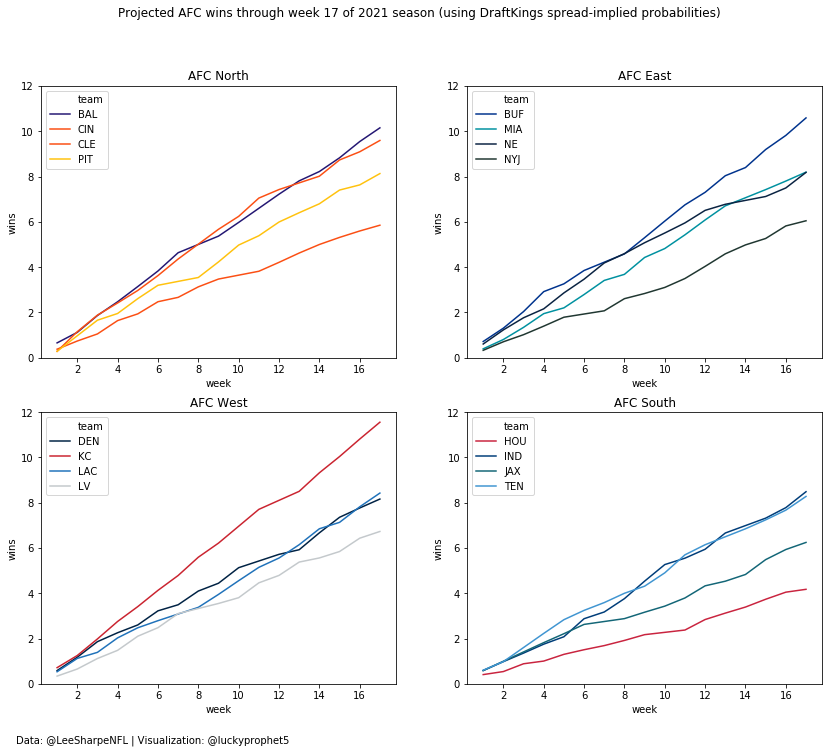

In [8]:
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}
divs = {
    'NFC':
    {
        'North':['GB','CHI','MIN','DET'],
        'East':['WAS','NYG','PHI','DAL'],
        'West':['SEA','LA','ARI','SF'],
        'South':['NO','TB','CAR','ATL']
    },
    'AFC':
    {
        'North':['PIT','BAL','CLE','CIN'],
        'East':['BUF','MIA','NE','NYJ'],
        'West':['KC','LV','LAC','DEN'],
        'South':['TEN','IND','HOU','JAX']
    }
}

fig, axs = plt.subplots(nrows=2, ncols=2)
ax=axs[0][0]
sns.lineplot(x='week',y='wins',hue='team', palette=COLORS, data=sched.loc[sched.team.isin(divs['AFC']['North'])], ax=ax)
ax.set(title="AFC North", ylim=(0,12))
ax=axs[0][1]
sns.lineplot(x='week',y='wins',hue='team', palette=COLORS, data=sched.loc[sched.team.isin(divs['AFC']['East'])], ax=ax)
ax.set(title="AFC East", ylim=(0,12))
ax=axs[1][0]
sns.lineplot(x='week',y='wins',hue='team', palette=COLORS, data=sched.loc[sched.team.isin(divs['AFC']['West'])], ax=ax)
ax.set(title="AFC West", ylim=(0,12))
ax=axs[1][1]
sns.lineplot(x='week',y='wins',hue='team', palette=COLORS, data=sched.loc[sched.team.isin(divs['AFC']['South'])], ax=ax)
ax.set(title="AFC South", ylim=(0,12))
fig.set_size_inches(14,11)
fig.suptitle("Projected AFC wins through week 17 of 2021 season (using DraftKings spread-implied probabilities)")
plt.figtext(0.1,0.05,"Data: @LeeSharpeNFL | Visualization: @luckyprophet5")

Text(0.1, 0.05, 'Data: @LeeSharpeNFL | Visualization: @luckyprophet5')

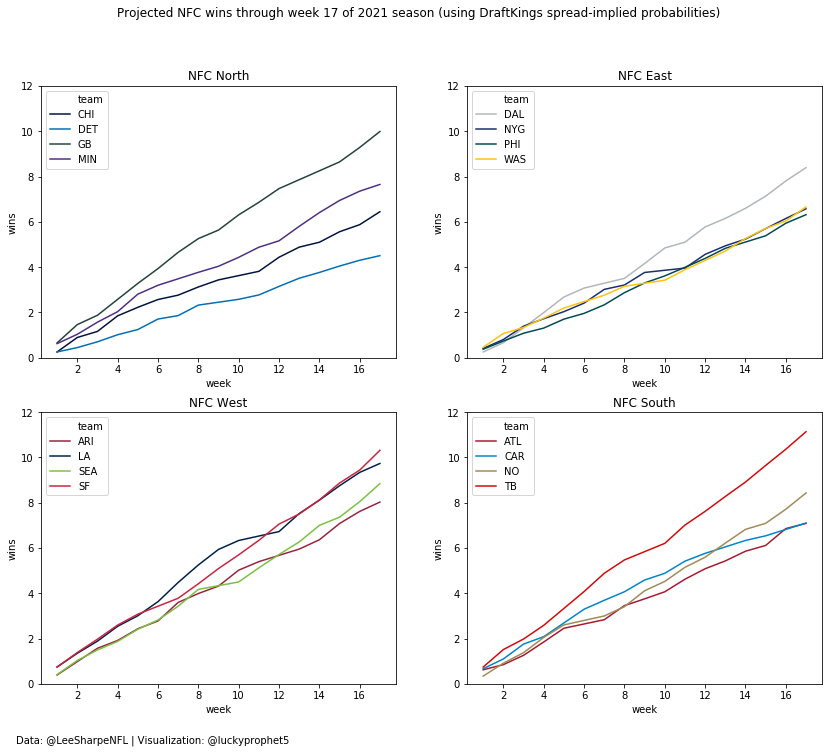

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2)
ax=axs[0][0]
sns.lineplot(x='week',y='wins',hue='team', palette=COLORS, data=sched.loc[sched.team.isin(divs['NFC']['North'])], ax=ax)
ax.set(title="NFC North", ylim=(0,12))
ax=axs[0][1]
sns.lineplot(x='week',y='wins',hue='team', palette=COLORS, data=sched.loc[sched.team.isin(divs['NFC']['East'])], ax=ax)
ax.set(title="NFC East", ylim=(0,12))
ax=axs[1][0]
sns.lineplot(x='week',y='wins',hue='team', palette=COLORS, data=sched.loc[sched.team.isin(divs['NFC']['West'])], ax=ax)
ax.set(title="NFC West", ylim=(0,12))
ax=axs[1][1]
sns.lineplot(x='week',y='wins',hue='team', palette=COLORS, data=sched.loc[sched.team.isin(divs['NFC']['South'])], ax=ax)
ax.set(title="NFC South", ylim=(0,12))
fig.set_size_inches(14,11)
fig.suptitle("Projected NFC wins through week 17 of 2021 season (using DraftKings spread-implied probabilities)")
plt.figtext(0.1,0.05,"Data: @LeeSharpeNFL | Visualization: @luckyprophet5")

In [10]:
sched.loc[sched.week==17].wins.sum()

256.0